## Scaling benchmarks for Birch clustering in scikit-learn


This notebook aims to compare the different ways of computing labels in Birch clustering (when the global clustering step is not used).


In [8]:
import numpy as np
import pandas as pd

from sklearn.cluster import Birch
from sklearn.metrics import v_measure_score
from sklearn.datasets import make_blobs
from sklearn.externals import joblib
from sklearn.metrics import v_measure_score
from sklearn.preprocessing import normalize
from sklearn.utils import gen_even_slices
from birch import Birch as Birch_PR

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

%load_ext memory_profiler

np.random.seed(42)

n_features = 100
dataset = 'lsa'

def _get_cluster_labels(brc, n_samples):
    labels = np.zeros(n_samples, dtype=int)
    cluster_id = 0
    for current_leaf in brc._get_leaves():
        for sc in current_leaf.subclusters_:
            labels[sc.samples_id_] = cluster_id
            cluster_id += 1
    return labels

def _out_of_core_birch(X):
    brc5 = Birch(n_clusters=None, compute_labels=True)
    for sl in gen_even_slices(X.shape[0], 1000):
        brc5.partial_fit(X[sl])
    return brc5

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Performance benchmarks


,fit (PR),fit (PR) + predict (iterate leaves),fit (master),fit (master) + predict (min dist) [out-of-core],fit (master) + predict (min distances),n_subclusters
5000,0.34,0.35,0.32,0.60,0.38,1687
10000,0.79,0.82,0.75,1.23,0.99,3219
15000,1.26,1.30,1.19,1.97,1.70,4656
20000,1.70,1.76,1.61,2.75,2.51,6096
50000,4.49,4.61,4.25,8.09,9.04,14343
100000,9.08,9.29,8.66,19.46,27.15,26986
200000,19.24,19.65,18.26,63.05,NaN,53311


# Memory benchmarks


,fit (PR),fit (PR) + predict (iterate leaves),fit (master),fit (master) + predict (min dist) [out-of-core],fit (master) + predict (min distances)
5000,0.10,0.10,0.10,0.10,0.10
10000,0.55,0.31,0.18,0.10,245.65
15000,23.29,23.29,22.89,0.10,555.60
20000,17.08,30.78,30.39,13.81,960.57
50000,44.24,44.24,41.22,15.48,5512.89
100000,112.83,92.37,86.46,36.66,20675.64
200000,220.26,228.77,180.53,172.59,NaN


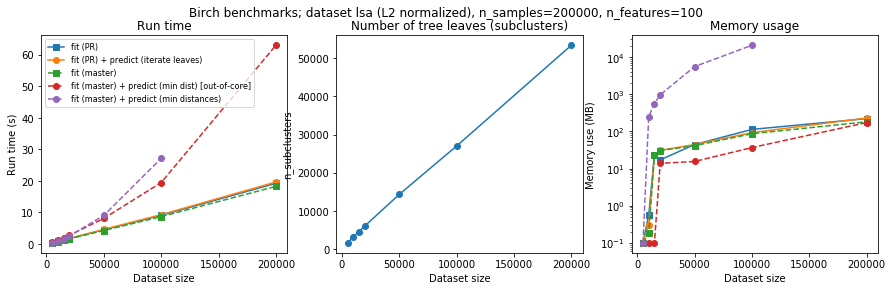

In [9]:
benchmarks = {'fit (master)': lambda X: Birch(n_clusters=None, compute_labels=False).fit(X),
              'fit (master) + predict (min distances)': lambda X: Birch(n_clusters=None, compute_labels=True).fit(X),
              'fit (master) + predict (min dist) [out-of-core]': _out_of_core_birch,
              'fit (PR)': lambda X: Birch_PR(n_clusters=None, compute_labels=False, compute_samples_indices=True).fit(X),
              'fit (PR) + predict (iterate leaves)': lambda X: _get_cluster_labels(Birch_PR(n_clusters=None, compute_samples_indices=True, compute_labels=False).fit(X), X.shape[0]),
              }


n_samples_arr = [5000, 10000, 15000, 20000, 50000, 100000, 200000]
res_cpu = []
res_mem = []

for n_samples in n_samples_arr:

    if dataset == 'rand':
        X = np.random.randn(n_samples, n_features) 
    elif dataset == 'blobs':
        X, y = make_blobs(n_samples, n_features=n_features)
    elif dataset == 'lsa':
        X = joblib.load('birch_data/lsi_700k-300dim.pkl')[:n_samples, :n_features]
    else:
        raise ValueError
    normalize(X, copy=False) 
    
    # performance benchmarks
    res_cpu_el = {}
    for key, func in benchmarks.items():
        try:
            t1 = %timeit -o -r1 -q func(X)
            res_cpu_el[key] = t1.average
        except MemoryError:
            pass

    try:
        labels = _get_cluster_labels(Birch_PR(n_clusters=None, compute_samples_indices=True, compute_labels=False).fit(X), X.shape[0])
        res_cpu_el['n_subclusters'] = len(np.unique(labels))
    except MemoryError:
        pass
    
    res_cpu.append(res_cpu_el)
   
    # memory benchmarks
    res_mem_el = {}
    for key, func in benchmarks.items():
        try:
            m1 = %memit -o -r1 -q func(X)
            res_mem_el[key] = max(max(m1.mem_usage) - m1.baseline, 0.1) # set some small floor for log scale
        except MemoryError:
            pass
    res_mem.append(res_mem_el)
    
df_cpu = pd.DataFrame(res_cpu, index=n_samples_arr).round(2)
print('# Performance benchmarks')
display(df_cpu)

df_mem = pd.DataFrame(res_mem, index=n_samples_arr).round(2)
print('# Memory benchmarks')
display(df_mem)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for key in df_cpu.columns:
    if key == 'n_subclusters':
        continue
    ls = 'solid' if 'PR' in key else 'dashed'
    marker = 'o' if 'predict' in key else 's'
    ax[0].plot(df_cpu.index, df_cpu[key], ls=ls, marker=marker, label=key)
    ax[2].semilogy(df_mem.index, df_mem[key], ls=ls, marker=marker)
_ = ax[0].legend(loc='best', prop={'size': 8})
ax[0].set_xlabel('Dataset size')
ax[0].set_ylabel('Run time (s)')

ax[1].plot(df_cpu.index, df_cpu.n_subclusters, marker='o')
ax[1].set_xlabel('Dataset size')
ax[1].set_ylabel('n_subclusters')

ax[2].set_xlabel('Dataset size')
ax[2].set_ylabel('Memory use (MB)')

ax[0].set_title('Run time')
ax[1].set_title('Number of tree leaves (subclusters)')
ax[2].set_title('Memory usage')

fig.suptitle('Birch benchmarks; dataset {} (L2 normalized), n_samples={}, n_features={}'.format(dataset, X.shape[0], X.shape[1]))